In [439]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt

orange = (230/255,159/255,0)
skyblue = (86/255,180/255,233/255)
green = (0,158/255,115/255)
yellow = (240/255,228/ 255,66/ 255)
blue = (0,114/ 255,178/255)
red = (213/ 255,94/255,0)
purple = (204/255,121/255,167/255)

import matplotlib
plt.rcParams['font.family'] = ['Helvetica']

## Read data

In [440]:
df = pd.read_excel('DATA.xlsx')

## Patient selection

This code runs simulations for four types of problems:

- **TPC**: Tumor positive + CAR-T cells.
- **TPCC**: Tumor positive + CAR-T cells + Cytokines.
- **TPNC**: Tumor positive + Tumor Negative + CAR-T cells.
- **TPNCC**: Tumor positive + Tumor Negative + CAR-T cells + Cytokines.

In [441]:
select_patient = 'P03'

# Select specific patient data
patient_data = df[df['ID'] == select_patient]

# Type of similation
sim = patient_data['TYPE'].values[0]

# Dose infusion protocol
protocol = int(patient_data['dose_switch'])

if sim == 'TPC':
    print ('Patient',select_patient, 'is simulated for Tumor positive + CAR-T cells.' )
elif sim == 'TPCC':
    print ('Patient',select_patient, 'is simulated for Tumor positive + CAR-T cells + Cytokines.' )
elif sim == 'TPNC':
    print ('Patient',select_patient, 'is simulated for Tumor positive + Tumor Negative + CAR-T cells.' )
elif sim == 'TPNCC':
    print ('Patient',select_patient, 'is simulated for Tumor positive + Tumor Negative + CAR-T cells + Cytokines.' )

if protocol == 0:
    print ('Patient',select_patient, 'received a single dose.' )
elif protocol == 1:
    print ('Patient',select_patient, 'received a fractioned dose (10%-30%-60%).' )

Patient P03 is simulated for Tumor positive + CAR-T cells + Cytokines.
Patient P03 received a fractioned dose (10%-30%-60%).


## Extract patient-specific parameters

In [442]:
tmax_CAR = patient_data.iloc[:, 3].values[0]
tmax_IL6 = patient_data.iloc[:, 4].values[0]

pat_param_list = patient_data.iloc[:, 5:32].values[0].tolist()

param_list = ['Ini_CAR', 'Ini_Tp', 'Ini_Tn', 'Ini_IL6',
              'e', 'gamma', 'kappa', 'muM', 'theta', 'muT',
              'r', 'B', 'A', 'n', 'mu_D', 'g0',
              'source_IL6', 'decay_IL6', 'alpha', 'dm', 'gB', 'gK', 'gC', 'Ini_Mi', 'sig_m', 'C','K']

param_dict = {param: 0 if np.isnan(value) else value for param, value in zip(param_list, pat_param_list)}

Ini_CAR, Ini_Tp, Ini_Tn, Ini_IL6, e, gamma, kappa, muM,theta, muT, r, B, A, n, mu_D, g0, source_IL6, decay_IL6, alpha, dm, gB, gK, gC, Ini_Mi, sig_m, C, K = list(param_dict.values())

In [443]:
def system(x, t, e, gamma, kappa, muM, theta, muT, r, B, A, n, mu_D, g0, source_IL6, decay_IL6, alpha, dm, gB, gK, gC, sig_m, C, K):
        
    CARI, CARE, CARM, TP, TN, Mi, Ma, CYT = x
           
    #F(Tp)
    F_Tp = TP/(A+TP)

    # --
    dCARI_dt = -n*F_Tp*CARI - mu_D*CARI
    dCARE_dt = n*F_Tp*CARI + kappa*F_Tp*CARE - e*(1-F_Tp)*CARE + theta*F_Tp*CARM - muT*CARE 
    dCARM_dt = e*(1-F_Tp)*CARE - theta*F_Tp*CARM - muM*CARM
    dTP_dt = r*TP*(1-((TP+TN)/K)) - gamma*(CARE/(B+CARE))*TP
    dTN_dt = r*TN*(1-((TP+TN)/K)) - g0*gamma*(CARE/(B+CARE))*TN
    
    #h(CARE,TP,Ma)
    h = gK*(CARE/(B+CARE))*(TP+g0*TN) + gB*F_Tp*CARE + gC*(Ma/(C+Ma))*CARE
    
    # --
    dMi_dt = sig_m - h*Mi - dm*Mi
    dMa_dt = h*Mi - dm*Ma
    dCYT_dt = source_IL6 + alpha*Ma - decay_IL6*CYT
    
    return [dCARI_dt,dCARE_dt,dCARM_dt,dTP_dt,dTN_dt,dMi_dt,dMa_dt,dCYT_dt]


## Perform simulations

- Set initial conditions;
- Solve ODEs
- Save Results

In [444]:
#Initial Conditions
CARI_ic = Ini_CAR
CARE_ic = 0.0
CARM_ic = 0.0
TP_ic = Ini_Tp
TN_ic = Ini_Tn
Mi_ic = Ini_Mi
Ma_ic = 0.0
CYT_ic = Ini_IL6

# Time points
tmax = tmax_CAR;dt = 0.1
times = np.arange(0, tmax + dt, dt)

# Results
CAR_I = [];CAR_E = []; CAR_M = [];T_P = [];T_N = [];M_i= []; M_a= []; IL6= []   

current_time = 0
while current_time <= tmax:           
    t_range = [current_time, current_time + dt]  
     
    args = (e, gamma, kappa, muM, theta, muT, r, B, A, n, mu_D, g0, source_IL6, decay_IL6, alpha, dm, gB, gK, gC, sig_m, C, K)
       
    y = odeint(system,t=(t_range[0],t_range[-1]), y0=[CARI_ic,CARE_ic,CARM_ic,TP_ic,TN_ic,Mi_ic,Ma_ic,CYT_ic],
               args=args)
    
    # Update initial conditions
    CARI_ic, CARE_ic, CARM_ic, TP_ic, TN_ic, Mi_ic, Ma_ic, CYT_ic = y[-1]
     
    # Avoid re-growth
    if CARE_ic <1:
        kappa = 0
    
    if protocol == 1:# Fractioned Dose
        if np.round(current_time,1)==1:
            CARI_ic = CARI_ic + 3*Ini_CAR #(30% of dose)
        elif np.round(current_time,1)==2:
            CARI_ic = CARI_ic + 6*Ini_CAR #(60% of dose)
           
    CAR_I.append(CARI_ic);CAR_E.append(CARE_ic);CAR_M.append(CARM_ic);T_P.append(TP_ic);T_N.append(TN_ic)
    M_i.append(Mi_ic); M_a.append(Ma_ic); IL6.append(CYT_ic)
    
    current_time += dt 
    
    if len(CAR_I) != len(times):
        times = np.arange(0, tmax + dt, dt)[:len(CAR_I)]


## Plot Results

- CAR-T cells + Tumor Cells
- Cytokine: IL-6

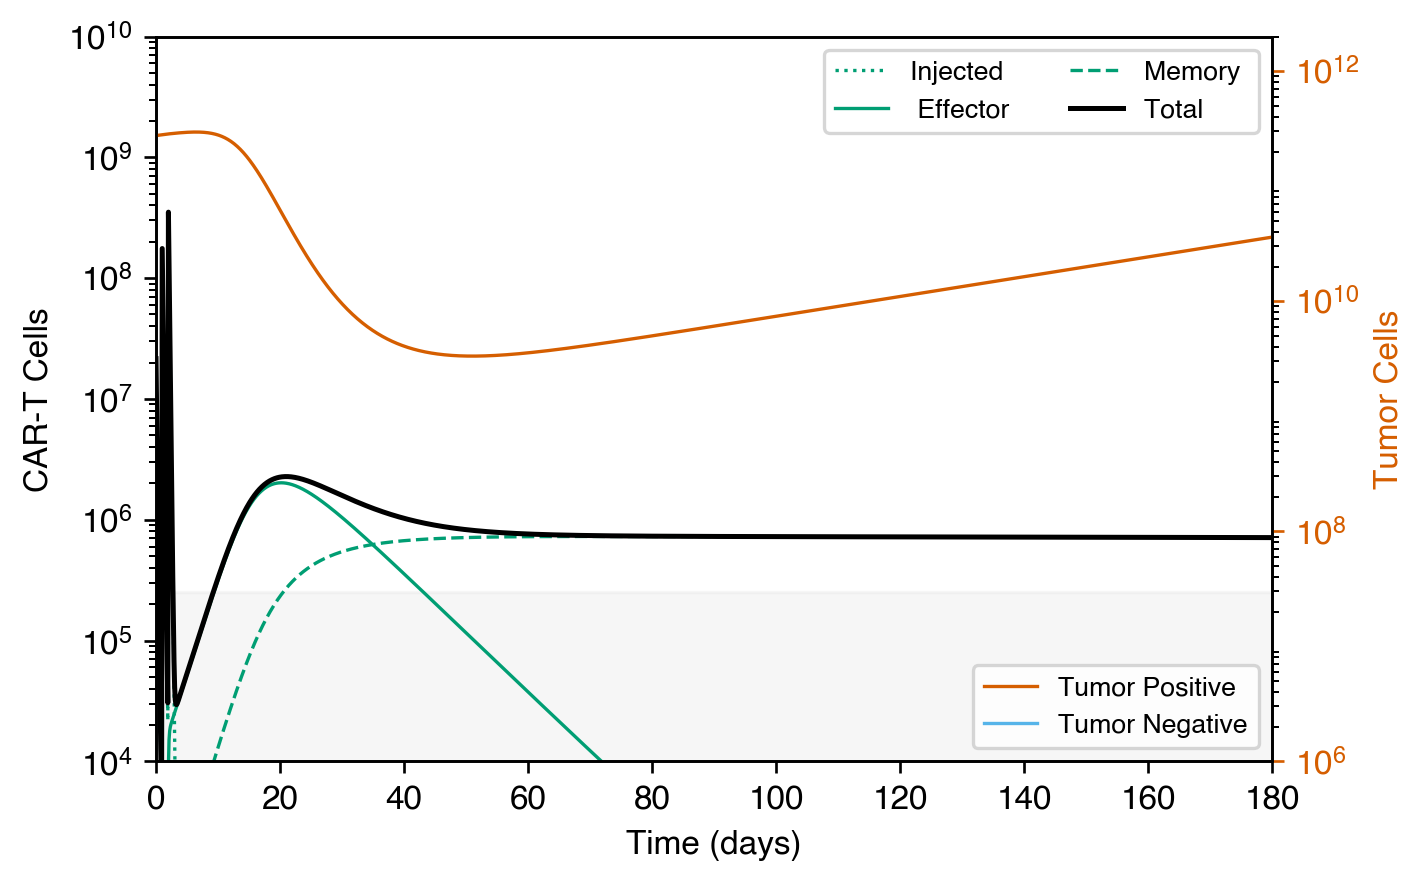

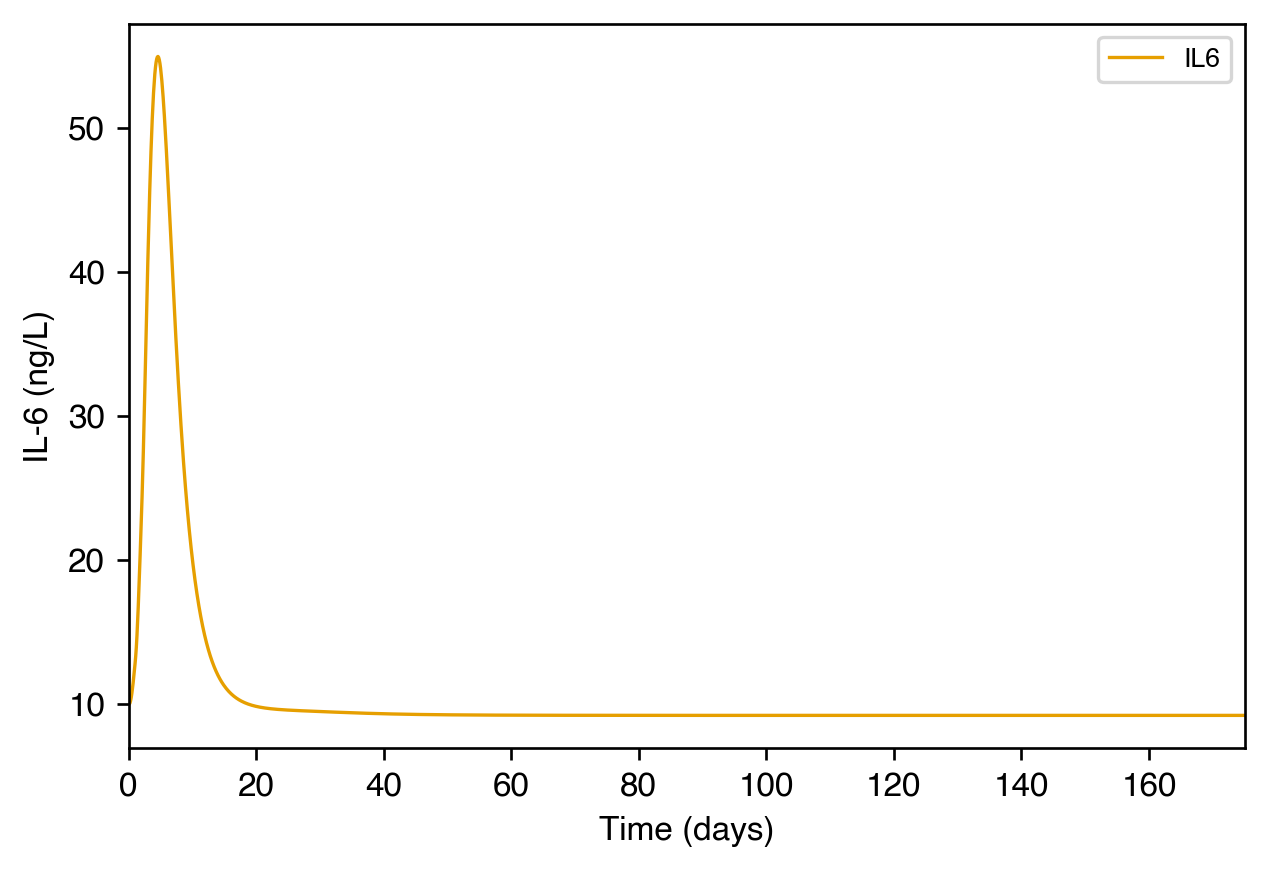

In [445]:
fig, ax = plt.subplots(dpi=240)
x1 = np.linspace(0, 0, 10)
x2 = np.linspace(times[-1], times[-1], 10)
    
ax.plot(times,  CAR_I, label= 'Injected ' ,color=green, linestyle='dotted', linewidth=1)
ax.plot(times,  CAR_E, label= ' Effector ' , color=green, linestyle='solid', linewidth=1)
ax.plot(times, CAR_M, label= 'Memory ', color=green, linestyle='dashed', linewidth=1)
ax.plot(times,  np.array(CAR_I)+np.array(CAR_E)+np.array(CAR_M), label= 'Total ' , color='black',linestyle='solid',linewidth=1.50)

ax.fill_betweenx(y=np.linspace(1e3, 2.5e5, 10), x1=x1, x2=x2, where=x2 >= x1, color='lightgrey', alpha=0.2)
plt.yscale("log")
plt.xlim(0,int(tmax_CAR))
plt.ylim(1e4,1e10)
ax.legend(ncol=2,loc='upper right',fontsize=8)
plt.xlabel('Time (days)')
plt.ylabel('CAR-T Cells');

ax2 = ax.twinx()

ax2.plot(times, T_P, label='Tumor Positive', linestyle='solid', color=red, linewidth=1)
ax2.plot(times, T_N, label='Tumor Negative', linestyle='solid', color=skyblue, linewidth=1)
        
    
ax2.set_ylim(1e6, 2e12)
ax2.set_yscale('log')
ytick_loc = [1e6, 1e8, 1e10, 1e12]
ax2.set_yticks(ytick_loc)
    
ax2.yaxis.offsetText.set_fontsize(10)
ax2.tick_params(axis='y', colors=red, labelsize=10)
ax2.legend(ncol=1,loc='lower right',fontsize=8)
ax2.set_ylabel('Tumor Cells', color=red);
plt.show()

#-------------------------------------------------
fig, ax = plt.subplots(dpi=240)
ax.plot(times,  IL6, label= 'IL6' ,color=orange, linestyle='solid', linewidth=1)

plt.xlim(0,int(tmax_IL6))
plt.legend(ncol=1,loc='upper right',fontsize=8)
plt.xlabel('Time (days)')
plt.ylabel('IL-6 (ng/L)');


plt.show()